In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from eemeter.weather.location import zipcode_to_usaf_station
from eemeter.weather import ISDWeatherSource

import datetime
import pytz

In [2]:
np.random.seed(123)
periods = 365*4+2
index = pd.date_range('2011-01-01 00:00:00Z', periods=periods, freq='D')

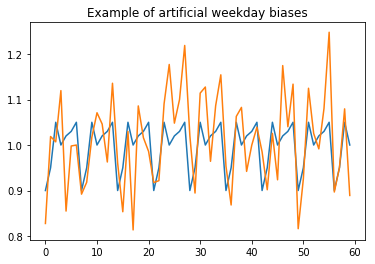

In [3]:
scale = 0.005

weekday_template = np.array([1.05, 1.0, 1.02, 1.03, 1.05, 0.9, 0.95])
weekday_bias_means = weekday_template.take(index.dayofweek)
weekday_biases = np.random.gamma(shape=weekday_bias_means * (1/scale), scale=scale)

plt.title('Example of artificial weekday biases')
plt.plot(weekday_bias_means[:60])
plt.plot(weekday_biases[:60])
plt.show()

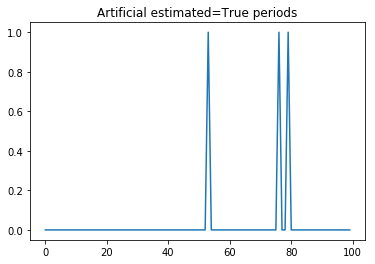

In [4]:
estimated = np.random.choice([True, False], size=(periods,), p=[0.05, 0.95])
plt.title('Artificial estimated=True periods')
plt.plot(estimated[:100])
plt.show()

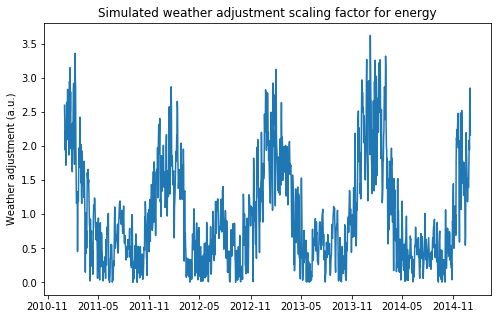

In [5]:
fig, ax = plt.subplots(figsize=(8,5))

station = zipcode_to_usaf_station("50321")
weather_source = ISDWeatherSource(station)
weather_source

temps = weather_source.indexed_temperatures(index, "degF")

# estimate of the days needing heat
hdd = np.maximum(65 - temps, 0)

# estimate of the days needing A/C
cdd = np.maximum(temps - 65, 0)

# estimate a heating/cooling scaling factor
hdd_cdd_norm = (hdd + cdd) / (cdd.mean() + hdd.mean())

est = pd.Series(hdd_cdd_norm, index=index)
lines = ax.plot(est)
ax.set_title('Simulated weather adjustment scaling factor for energy')
ax.set_ylabel('Weather adjustment (a.u.)')

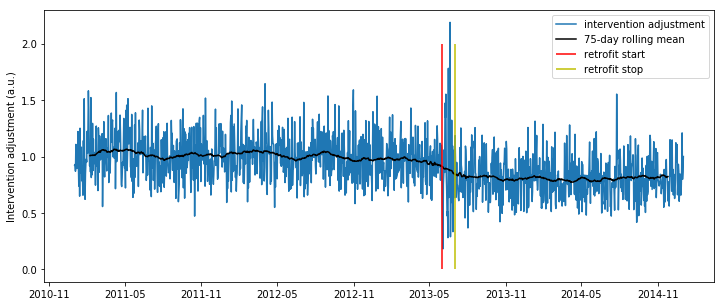

In [6]:
fig, ax = plt.subplots(figsize=(12, 5))
noise_scale = 0.04
pre_noise = np.random.gamma(shape=1/noise_scale, scale=noise_scale, size=periods)
during_noise = np.random.gamma(shape=0.9/noise_scale/5, scale=noise_scale*5, size=periods)
post_noise = np.random.gamma(shape=0.8/noise_scale, scale=noise_scale, size=periods)


retrofit_start_date = datetime.datetime(2013,6,1, tzinfo=pytz.UTC)
retrofit_end_date = datetime.datetime(2013,7,1, tzinfo=pytz.UTC)

intervention_adjustment = (
    ((index <= retrofit_start_date) * pre_noise) +
    (((index > retrofit_start_date) & (index < retrofit_end_date)) * during_noise) +
    ((index >= retrofit_end_date) * post_noise)
)

ax.plot(index, intervention_adjustment, label='intervention adjustment', zorder=2)
# compute a simple rolling mean with pandas
rolling_mean = pd.Series(intervention_adjustment, index=index).rolling(75, center=True).mean()
ax.plot(rolling_mean, 'k', label='75-day rolling mean', zorder=2)
ax.vlines(retrofit_start_date, 0, 2, 'r', zorder=10, label='retrofit start')
ax.vlines(retrofit_end_date, 0, 2, 'y', zorder=10, label='retrofit stop')
ax.set_ylabel('Intervention adjustment (a.u.)')
leg = ax.legend()

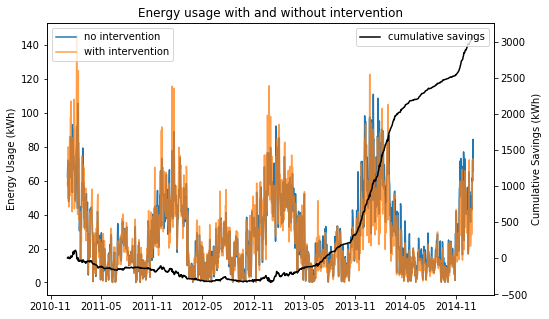

In [7]:
fig, ax = plt.subplots(figsize=(8,5))
axdiff = ax.twinx()

avg_kwh_per_day = 10608.0 / 365

values_no_intervention = avg_kwh_per_day * hdd_cdd_norm * weekday_biases
values_with_intervention = intervention_adjustment * values_no_intervention
diff = values_no_intervention - values_with_intervention
axdiff.plot(diff.cumsum(), 'k', label='cumulative savings')
axdiff.legend(loc=1)
axdiff.set_ylabel("Cumulative Savings (kWh)")

ax.plot(values_no_intervention, label='no intervention')
ax.plot(values_with_intervention, label='with intervention', alpha=.75)
ax.set_title("Energy usage with and without intervention")
ax.set_ylabel("Energy Usage (kWh)")
leg = ax.legend(loc=2)

In [8]:
energy_df = pd.DataFrame({
        "project_id": "ABC",
        "trace_id": "DEF",
        "date": index,
        "value": values_with_intervention.round(decimals=1),
        "unit": "kWh",
        "fuel": "electricity",
        "estimated": estimated,
    }, index=index, columns=["project_id", "trace_id", "date", "value", "unit", "fuel", "estimated"])

energy_df.set_value(index[-1], "value", np.nan)
energy_df.set_value(index[-1], "estimated", False)

energy_df.to_csv('sample-energy-data_project-ABC_zipcode-50321.csv',
                 index=False, date_format="%Y-%m-%dT%H:%M:%S%z")

In [9]:
project_df = pd.DataFrame({
        "project_id": "ABC",
        "zipcode": "50321",
        "retrofit_start_date": retrofit_start_date,
        "retrofit_end_date": retrofit_end_date,
    }, index=[0], columns=["project_id", "zipcode", "retrofit_start_date", "retrofit_end_date"])

project_df.to_csv('sample-project-data.csv',
          index=False, date_format="%Y-%m-%dT%H:%M:%S%z")